# 0. Setup environment

In [ ]:
%%capture
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA\ 301\ Advanced\ DS/final_project

%pip install -r requirements.txt
%pip install wandb -Uq

In [ ]:
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions
import torch
import wandb
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")

def get_best_torch_device():
    if torch.cuda.is_available():  # CUDA
        return "cuda"
    elif torch.backends.mps.is_available():  # Apple Silicon / GPU
        return "mps"
    else:  # Fallback to CPU
        return "cpu"

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Configure hyperparameters (+ random state)
random_state = 13117

device = get_best_torch_device()
print(f"Currently using {device.upper()} for training!")

Currently using CUDA for training!


# 1. Load Sweep results and checkpoints

In [ ]:
!ls -als data/

total 443491
 45402 -rw------- 1 root root  46491149 Nov  3 20:17 amazon_reviews.zip
 20421 -rw------- 1 root root  20910546 Nov  7 03:30 balanced_data.csv
 24743 -rw------- 1 root root  25335945 Nov  9 04:47 balanced_with_labels.csv
 44895 -rw------- 1 root root  45972134 Dec  2 10:22 balanced_with_labels_v2.csv
    58 -rw------- 1 root root     58866 Dec 17 21:32 best_chkpt_final_4.pickle
138370 -rw------- 1 root root 141690237 Oct 16 22:26 Cell_Phones_and_Accessories_5.json
     4 drwx------ 2 root root      4096 Nov 29 23:31 checkpoints
 95424 -rw------- 1 root root  97713795 Nov  6 21:40 cleaned_data.csv
     4 drwx------ 2 root root      4096 Dec  2 06:56 .ipynb_checkpoints
 24768 -rw------- 1 root root  25362418 Nov  7 06:04 labels.csv
 44310 -rw------- 1 root root  45372886 Dec  2 10:22 labels_v2.csv
     4 drwx------ 2 root root      4096 Dec  2 06:50 label_temp
  1297 -rw------- 1 root root   1327715 Dec  2 17:28 sweep_result_loss_mp_fast_final_2.pickle
  1205 -rw------- 1 ro

In [ ]:
trained_models = torch.load(
    "data/sweep_result_loss_mp_fast_final_5.pickle",
    map_location=torch.device(get_best_torch_device())
  )

In [ ]:
len(trained_models)

32

In [ ]:
trained_models_sorted = dict(sorted(trained_models.items()))

In [ ]:
print(
    "Here are the losses from trained combinations in increasing order:\n",
    "\n\t".join([] + list([str(key) for key in trained_models_sorted.keys()])),
)

Here are the losses from trained combinations in increasing order:
 0.7753607630729675
	0.7830576300621033
	0.7870684266090393
	0.787203848361969
	0.7892823815345764
	0.7921412587165833
	0.8049570322036743
	0.8871960639953613
	0.93113112449646
	0.9314156770706177
	0.9319742918014526
	0.9354130029678345
	0.9398469924926758
	0.9447182416915894
	0.9719501733779907
	0.9803558588027954
	0.9813348650932312
	0.9815859198570251
	1.0163497924804688
	1.061025857925415
	1.2026724815368652
	1.2369810342788696
	1.2639625072479248
	1.286023736000061
	1.29745352268219
	1.5163432359695435
	1.5222514867782593
	1.5344938039779663
	1.9657423496246338
	1.975252628326416
	2.3748865127563477
	2.4021496772766113


In [ ]:
keys = list(trained_models_sorted.keys())
props_best = trained_models[keys[0]]

In [ ]:
print("The model with best results is using the following hyperparameters:")

for k, v in props_best["config"].items():
    print(f"\t{k}: {v}")

print("Which yields the following results: ")

for k, v in props_best.items():
    if k in ["result_df", "chkpt", "config"]:
        continue

    print(f"\t{k}: {v}")

The model with best results is using the following hyperparameters:
	activation_func: leaky_relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 3
	optimizer: adam
Which yields the following results: 
	val_loss: 0.7753607630729675
	val_acc: 0.6425
	train_acc: 0.6456428571428572


,epoch,train_loss,val_loss,val_accuracy,train_accuracy
0,0,2.258735,2.040329,0.425333,0.427250
1,1,1.672299,1.467407,0.584000,0.573357
2,2,1.338679,1.178955,0.604333,0.610071
3,3,1.140852,1.108477,0.593333,0.601286
4,4,1.023751,1.255815,0.564167,0.569357
...,...,...,...,...,...
123,123,0.762388,0.781245,0.640833,0.642500
124,124,0.755492,0.764820,0.642333,0.648821
125,125,0.755523,0.740205,0.642500,0.651750
126,126,0.756050,0.745802,0.644333,0.648679


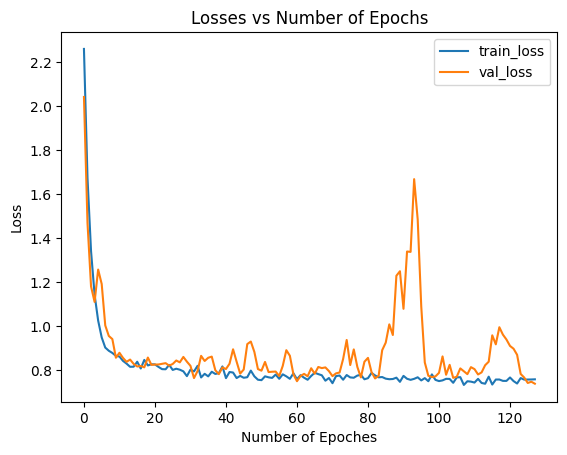

In [ ]:
df_results = props_best["result_df"]

display(df_results)

# train_loss and val_loss vs epoch
pyplot.plot(df_results["train_loss"], label="train_loss")
pyplot.plot(df_results["val_loss"], label="val_loss")
pyplot.xlabel("Number of Epoches")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.title(f"Losses vs Number of Epochs")
pyplot.show()

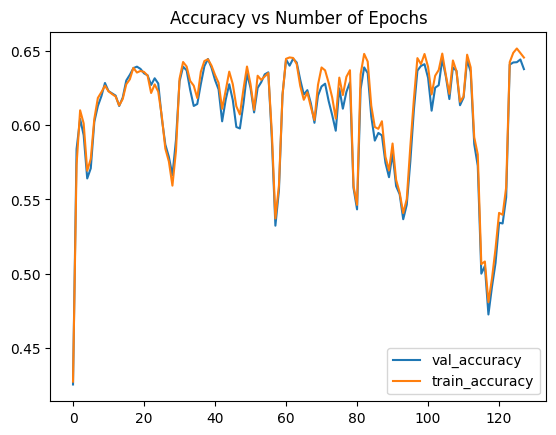

In [ ]:
pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
pyplot.plot(df_results["train_accuracy"], label="train_accuracy")
pyplot.title(f"Accuracy vs Number of Epochs")
pyplot.legend()
pyplot.show()

In [ ]:
columns = list(
    set(
        list(props_best["config"].keys())  # Weights and Biases config
        + [
            k for k in props_best.keys() if k not in ["config", "result_df", "chkpt"]
        ]  # telemetry data
        + ["best_epoch", "train_loss"]  # Internal telemetry data
    )
)

In [ ]:
rows = []

for k, v in trained_models_sorted.items():
    values = {}

    for key, value in v.items():
        if key in columns:
            values[key] = value

    for key, value in v["config"].items():
        if key in columns:
            values[key] = value

    values["best_epoch"] = v["chkpt"]["epoch"]
    values["train_loss"] = (v["chkpt"]["loss"]).cpu().detach().numpy()

    val_arr = [values[key] for key in columns]
    rows.append(val_arr)

df_stats = pandas.DataFrame(columns=columns, data=rows)

In [113]:
df_stats

,learning_rate,activation_func,train_loss,is_batch_norm,optimizer,train_acc,val_acc,n_layers,batch_size,n_epochs,best_epoch,val_loss
0,0.100,leaky_relu,0.7555226,True,adam,0.645643,0.642500,3,8192,128,125,0.775361
1,0.100,leaky_relu,0.74739397,True,adam,0.636214,0.638000,4,16384,128,126,0.783058
2,0.100,leaky_relu,0.73156375,True,adam,0.591179,0.641667,4,8192,128,123,0.787068
3,0.100,relu,0.7696037,True,adam,0.626929,0.640333,3,16384,128,121,0.787204
4,0.100,leaky_relu,0.767565,True,adam,0.576750,0.643000,3,16384,128,116,0.789282
5,0.100,leaky_relu,0.7709617,True,adam,0.637143,0.643667,3,16384,128,78,0.792141
6,0.100,leaky_relu,0.7566696,True,adam,0.593500,0.630167,4,16384,128,111,0.804957
7,0.010,leaky_relu,0.8114387,True,adam,0.572107,0.624167,2,8192,128,120,0.887196
8,0.100,relu,0.91225463,True,sgd,0.644750,0.638333,3,16384,128,127,0.931131
9,0.100,relu,0.92495865,True,sgd,0.640929,0.640667,3,16384,128,127,0.931416


In [ ]:
df_stats.describe()

,learning_rate,train_acc,val_acc,n_layers,batch_size,n_epochs,best_epoch,val_loss
count,32.000000,32.000000,32.000000,32.000000,32.00000,32.0,32.000000,32.000000
mean,0.045000,0.611857,0.624792,3.093750,14080.00000,128.0,120.812500,1.174737
std,0.046264,0.041873,0.033564,0.777065,3742.13353,0.0,10.996884,0.450182
min,0.005000,0.484893,0.487667,2.000000,8192.00000,128.0,78.000000,0.775361
25%,0.005000,0.592920,0.627000,2.750000,8192.00000,128.0,119.500000,0.920147
50%,0.010000,0.629964,0.637000,3.000000,16384.00000,128.0,126.000000,0.980845
75%,0.100000,0.641080,0.640417,4.000000,16384.00000,128.0,127.000000,1.288881
max,0.100000,0.651786,0.645000,4.000000,16384.00000,128.0,127.000000,2.402150


In [ ]:
# good_keys = df_not_overfit["val_loss"].tolist()
# good_model_1 = trained_models[good_keys[0]]

# 2. Profile the best model

In [ ]:
def describe_model(model_info, name: str = ""):
    print(f"The model {name} is using the following hyperparameters:")

    for k, v in model_info["config"].items():
        print(f"\t{k}: {v}")

    print("Which yields the following results: ")

    for k, v in model_info.items():
        if k in ["result_df", "chkpt", "config"]:
            continue

        print(f"\t{k}: {v}")

    df_results = model_info["result_df"]

    # train_loss and val_loss vs epoch
    pyplot.plot(df_results["train_loss"], label="train_loss")
    pyplot.plot(df_results["val_loss"], label="val_loss")
    pyplot.xlabel("Number of Epoches")
    pyplot.ylabel("Loss")
    pyplot.legend()
    pyplot.title(f"Losses vs Number of Epochs ({name})")
    pyplot.show()

    pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
    pyplot.plot(df_results["train_accuracy"], label="train_accuracy")
    pyplot.title(f"Accuracy vs Number of Epochs")
    pyplot.legend()
    pyplot.show()

The model good_model_1 is using the following hyperparameters:
	activation_func: leaky_relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 3
	optimizer: adam
Which yields the following results: 
	val_loss: 0.7753607630729675
	val_acc: 0.6425
	train_acc: 0.6456428571428572


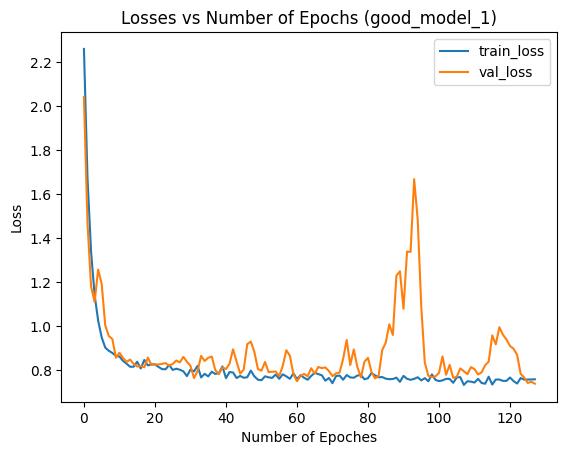

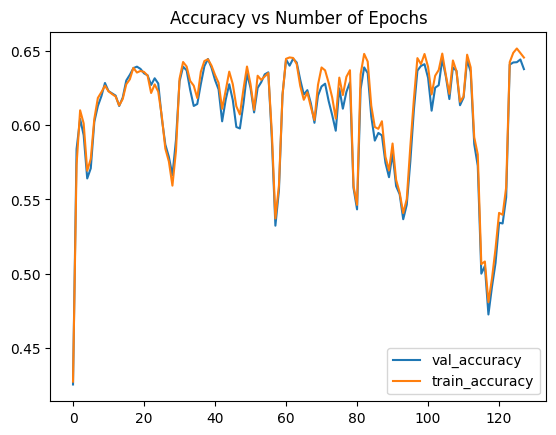

In [ ]:
describe_model(props_best, "good_model_1")

In [ ]:
class FairDataset(torch.utils.data.Dataset):
    def __init__(self, df_input):
        df_x = df_input[
            [
                c
                for c in df_input.columns
                if c not in ["review_text", "rating", "length"]
            ]
        ]
        df_y = df_input["rating"]
        self.features = torch.tensor(df_x.values, dtype=torch.float32).to(device)
        self.labels = torch.tensor(df_y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def spawn_layers(
    n_layers,
    input_size,
    output_size,
    is_batch_norm=True,
    activation_func=nn.ReLU,
    output_func=nn.LogSoftmax,
):
    layers = []
    prev_hidden = input_size

    for i in range(n_layers):
        hidden_size = int((prev_hidden + output_size) / 2)

        layers += [
            nn.Linear(in_features=prev_hidden, out_features=hidden_size),
            nn.BatchNorm1d(hidden_size) if is_batch_norm else nn.Identity(),
            activation_func(),
        ]

        prev_hidden = hidden_size

    return layers + [output_func(dim=1)]

# Spawns a model we trained
def spawn_model(props):


    chkpt = props["chkpt"]

    params = chkpt["params"]

    batch_size = params["batch_size"]
    n_layers = params["n_layers"]
    learning_rate = params["learning_rate"]
    n_epochs = params["n_epochs"]
    is_batch_norm = params["is_batch_norm"]
    input_size = chkpt["input_size"]
    output_size = chkpt["output_size"]

    optimizer_func = (
        torch.optim.Adam if params["optimizer"] == "adam" else torch.optim.SGD
    )
    activation_func = (
        nn.LeakyReLU if params["activation_func"] == "leaky_relu" else nn.ReLU
    )

    model = nn.Sequential(
        *spawn_layers(
            n_layers,
            input_size,
            output_size,
            activation_func=activation_func,
            is_batch_norm=is_batch_norm,
        )
    )

    model.load_state_dict(chkpt["model_state_dict"])
    model.to(get_best_torch_device())
    model.eval()

    return model

In [ ]:
best_model = spawn_model(props_best)

In [ ]:
h_test_size = 0.15
h_validation_size = 0.15

# Load data in
label_data = pandas.read_csv("data/balanced_with_labels_v2.csv")

# Get rid of three-star reviews as it kinda confuses our algorithm
label_data = label_data[label_data["rating"] != 3]

# Shuffle data
label_data = label_data.sample(frac=1, random_state=random_state)
label_data.rename(columns={"Unnamed: 0" : "length"},inplace=True)

# Data splitting
train_set, tmp_set = train_test_split(
    label_data, test_size=h_test_size + h_validation_size, random_state=random_state
)
test_set, validation_set = train_test_split(
    tmp_set,
    test_size=h_validation_size / (h_validation_size + h_test_size),
    random_state=random_state,
)

# Convert to datasets
ds_train = FairDataset(train_set)
ds_test = FairDataset(test_set)
ds_validation = FairDataset(validation_set)

# Make data loader
loader_test = DataLoader(ds_test, batch_size=1024, shuffle=False)

In [ ]:
y_true = []
y_pred = []

for inputs, labels in loader_test:
  outputs = best_model(inputs)
  _, predicted = torch.max(outputs, 1)

  y_true += labels.cpu().tolist()
  y_pred += predicted.cpu().tolist()


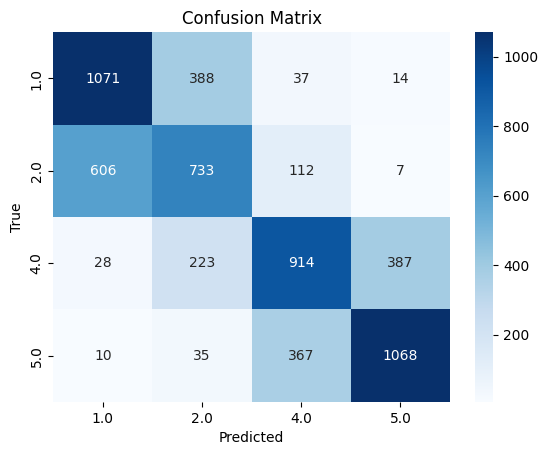

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=numpy.unique(y_true), yticklabels=numpy.unique(y_true))
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')

accuracies = conf_matrix.diagonal()/conf_matrix.sum(axis=1)

In [ ]:
from sklearn.metrics import precision_score, classification_report

precision_per_class = precision_score(y_true, y_pred, average=None)


precision_df = pandas.DataFrame({'Rating': [1,2,4,5], 'Precision': precision_per_class})

# Print precision per class
print("Precision per class:")
display(precision_df)

# for rating, precision in zip([1,2,4,5], precision_per_class):
#     print(f'Precision for predicting {rating}-star ratings: {precision}')

# Print classification report for additional information
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Precision per class:


,Rating,Precision
0,1,0.624490
1,2,0.531545
2,4,0.639161
3,5,0.723577



Classification Report:
              precision    recall  f1-score   support

         1.0       0.62      0.71      0.66      1510
         2.0       0.53      0.50      0.52      1458
         4.0       0.64      0.59      0.61      1552
         5.0       0.72      0.72      0.72      1480

    accuracy                           0.63      6000
   macro avg       0.63      0.63      0.63      6000
weighted avg       0.63      0.63      0.63      6000



In [ ]:
input_columns = props_best["chkpt"]["input_columns"]

In [ ]:
!cd /content && wget https://server.bridgesu.org/docs/amazon_fine_foods_review.csv

--2023-12-18 01:03:46--  https://server.bridgesu.org/docs/amazon_fine_foods_review.csv
Resolving server.bridgesu.org (server.bridgesu.org)... 54.213.197.97
Connecting to server.bridgesu.org (server.bridgesu.org)|54.213.197.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300904694 (287M) [application/octet-stream]
Saving to: ‘amazon_fine_foods_review.csv.1’

amazon_fine_foods_r 100%[===================>] 286.96M  69.0MB/s    in 4.4s    

2023-12-18 01:03:51 (65.0 MB/s) - ‘amazon_fine_foods_review.csv.1’ saved [300904694/300904694]



In [ ]:
df_fine_foods_review = pandas.read_csv("/content/amazon_fine_foods_review.csv")

In [ ]:
df_fine_foods_review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 0, 'Rating')

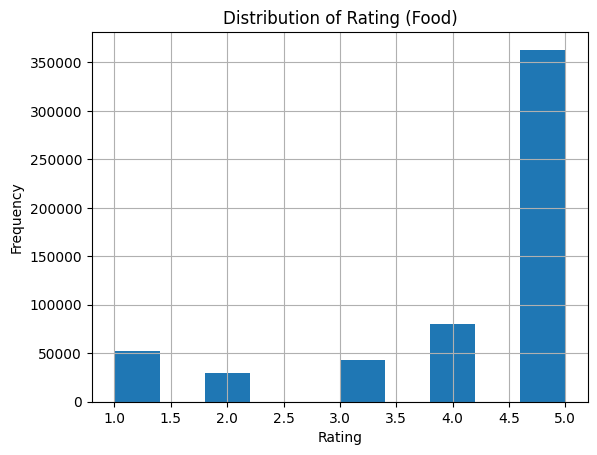

In [116]:
df_fine_foods_review.hist(column=["Score"])
pyplot.title("Distribution of Rating (Food)")
pyplot.ylabel("Frequency")
pyplot.xlabel("Rating")

In [ ]:
# Rename columns to fit FairDataset
df_less_col = df_fine_foods_review.drop(columns=["Id",
                                   "ProductId",
                                   "UserId",
                                   "ProfileName",
                                   "HelpfulnessNumerator",
                                   "HelpfulnessDenominator",
                                   "Time",
                                   "Summary"
                                   ]
                          )

df_food_clean = df_less_col.rename(columns={"Text": "review_text","Score" : "rating"})

# Drop 3-star ratings because people don't really understand what is mediocre
df_food_clean = df_food_clean[df_food_clean["rating"] != 3]

df_food_clean.dropna(inplace=True)
df_food_clean.reset_index(inplace=True, drop=True)

In [ ]:
df_food_clean.head()

,rating,review_text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [ ]:
df_food_clean.describe()

,rating
count,525814.000000
mean,4.279148
std,1.316725
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
arr_df_ratings = [
    df_food_clean[df_food_clean["rating"] == group][:500] for group in [1,2,4,5]
]

df_food_equal = pandas.concat(arr_df_ratings)

In [ ]:
df_food_equal.head()

,rating,review_text
1,1,Product arrived labeled as Jumbo Salted Peanut...
12,1,My cats have been happily eating Felidae Plati...
26,1,"The candy is just red , No flavor . Just plan..."
47,1,"This oatmeal is not good. Its mushy, soft, I d..."
57,1,Arrived in 6 days and were so stale i could no...


In [ ]:
# Load BART model
from transformers import pipeline

classifier = pipeline(
    "zero-shot-classification", model="facebook/bart-large-mnli", device_map="auto"
)

In [ ]:
class FairNoLabel(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df["review_text"].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
ds_food = FairNoLabel(df_food_equal)
classes = list(input_columns)

In [ ]:
n_entries = len(ds_food)
idx = 0
diff = 0
h_batch_size=32
label_rows = []

for r in classifier(ds_food, classes, batch_size=h_batch_size):

    print(f"\rPROGRESS: {idx + 1} / {n_entries}", end="")
    row = [r["sequence"]]

    for c in classes:
        row.append(r["scores"][r["labels"].index(c)])

    label_rows.append(row)
    idx += 1

    # Purge cache once in a while
    if idx - diff > h_batch_size * 2:
        torch.cuda.empty_cache()
        diff = idx

PROGRESS: 2000 / 2000

In [ ]:
df_label_food = pandas.DataFrame(label_rows, columns=["review_text"] + classes)
df_label_food.to_csv("data/df_labeled_food.csv", index=False)

df_food_w_label = pandas.merge(
    df_label_food, df_food_equal, on="review_text", how="inner")

In [ ]:
df_food_w_label.head()

,review_text,worst,okay,average,top-notch,satisfactory,below expectations,unsatisfactory,bad,so-so,...,good,outstanding,mediocre,commendable,acceptable,disappointing,excellent,above average,defective,rating
0,Product arrived labeled as Jumbo Salted Peanut...,0.004996,0.005220,0.008572,0.001335,0.001583,0.269322,0.063359,0.104278,0.034322,...,0.011007,0.003417,0.017245,0.001569,0.004552,0.055991,0.001414,0.011812,0.281955,1
1,My cats have been happily eating Felidae Plati...,0.001533,0.004680,0.005597,0.004901,0.004164,0.136072,0.193947,0.131666,0.090141,...,0.021730,0.002855,0.016752,0.003513,0.010342,0.248871,0.001981,0.011802,0.021769,1
2,"The candy is just red , No flavor . Just plan...",0.008571,0.000502,0.000370,0.000350,0.000863,0.163729,0.144287,0.103747,0.127687,...,0.001012,0.000488,0.111131,0.000398,0.000535,0.139009,0.000381,0.000690,0.091830,1
3,"This oatmeal is not good. Its mushy, soft, I d...",0.014283,0.000589,0.000716,0.000159,0.000498,0.134814,0.162709,0.147716,0.051098,...,0.000646,0.000142,0.085522,0.000634,0.000465,0.194029,0.000126,0.000367,0.054792,1
4,Arrived in 6 days and were so stale i could no...,0.015842,0.003070,0.001231,0.001376,0.003127,0.126798,0.156920,0.163670,0.019285,...,0.010969,0.001809,0.009074,0.001074,0.004379,0.232417,0.001387,0.005654,0.130528,1


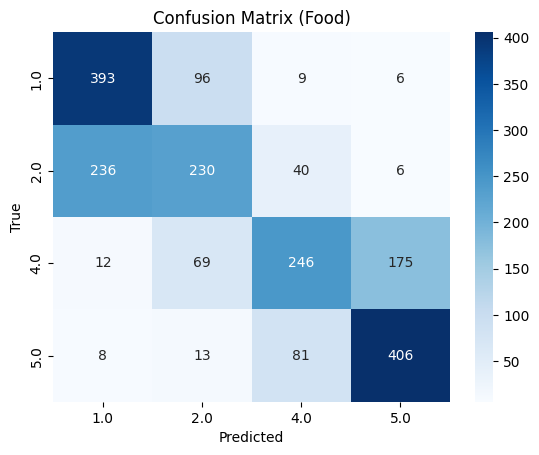

In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# df_food_w_label.dropna(inplace=True)
# df_food_w_label.reset_index(inplace=True, drop=True)

ds_fair_food = FairDataset(df_food_w_label)
loader_food = DataLoader(ds_fair_food, batch_size=1024, shuffle=True)

y_food_true = []
y_food_pred = []

for inputs, labels in loader_food:
  outputs = best_model(inputs)
  _, predicted = torch.max(outputs, 1)

  y_food_true += labels.cpu().tolist()
  y_food_pred += predicted.cpu().tolist()

conf_matrix = confusion_matrix(y_food_true, y_food_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=numpy.unique(y_true), yticklabels=numpy.unique(y_true))
pyplot.title('Confusion Matrix (Food)')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.show()


In [112]:
precision_per_class = precision_score(y_food_true, y_food_pred, average=None)


precision_df = pandas.DataFrame({'Rating': [1,2,4,5], 'Precision': precision_per_class})

# Print precision per class
print("Precision per class:")
display(precision_df)

# for rating, precision in zip([1,2,4,5], precision_per_class):
#     print(f'Precision for predicting {rating}-star ratings: {precision}')

# Print classification report for additional information
print("\nClassification Report:")
print(classification_report(y_food_true, y_food_pred))

Precision per class:


,Rating,Precision
0,1,0.605547
1,2,0.563725
2,4,0.654255
3,5,0.684654



Classification Report:
              precision    recall  f1-score   support

         1.0       0.61      0.78      0.68       504
         2.0       0.56      0.45      0.50       512
         4.0       0.65      0.49      0.56       502
         5.0       0.68      0.80      0.74       508

    accuracy                           0.63      2026
   macro avg       0.63      0.63      0.62      2026
weighted avg       0.63      0.63      0.62      2026



In [119]:
classes

['worst',
 'okay',
 'average',
 'top-notch',
 'satisfactory',
 'below expectations',
 'unsatisfactory',
 'bad',
 'so-so',
 'neutral',
 'satisfying',
 'amazing',
 'impressive',
 'fantastic',
 'poor',
 'good',
 'outstanding',
 'mediocre',
 'commendable',
 'acceptable',
 'disappointing',
 'excellent',
 'above average',
 'defective']